<a href="https://colab.research.google.com/github/akscent/Hacks/blob/main/glowbyte_ts_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Импорт

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, mean_absolute_percentage_error, mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, LSTM, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
from keras.models import save_model, load_model


import re
import os

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from pylab import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (7, 5)

## Словарь для предобработки

In [ ]:
dct_to_replace = {

    'ливневый|ливн|ливнем|ливни': 'ливень',
    'краткосрочно|кр|вр|временами|временный|врем': 'краткосрочный',

    'снежная|снегопад|снегом|обледенение|снеж|снегодождь|ледяной|снежные|снежок|сн|пурга|метель|с|лед|лёд': 'снег',
    'сн дождь': 'снег дождь',
    'мокр|сыро': 'мокрый',
    'сухие': 'сухой',

    'крапает|дождик|дождем|дожди|дожь': 'дождь',

    'сев': 'северный',
    'востоке|вост': 'восточный',
    'юго': 'южный',
    'зап': 'западный',

    'градом': 'град',
    'грозы|гром': 'гроза',
    'молнии': 'молния',
    'солнце': 'солнечно',
    'душно|душновато': 'жарко',
    'тает|комфортно|комфорт': 'тепло',
    'осадков': 'осадки',
    'шт': 'шторм',

    'ветра|порывы|порыв|ветерок|ветрище|ветерк|ветром': 'ветер',

    'моровь|морось|морос|моромь|слепой|изморозь': 'мороз',

    'хол|прохладно|иней|заморозки|поземка|поземный': 'холодно',

    'очень|затяж|сплошн|сплош|сплошная|круп|крупный|преим|сильный|сил|крупа|проливной|оч|густой|интенсивности|разной': 'много',

    'тихий|легкий|легкая|легк|зябко|мелкий|слаб|слабый|слабая|неб|небольшой|мало|штиль': 'лёгкий',

    'возможна|возм|в|мест|мастами|местами': 'возможно',

    'перем|пер|п': 'переменная',

    'облс|об|обл|облч|облач|облачн|облачность|пушистый|хлопьями': 'облачно',

    'малообл|малобл|малооб|перообл': 'переменная облачно',

    'обл с пр|обл с проясн': 'облачно прояснения',

    'проясн|пр|просн|прясн': 'прояснения',

    'пасмурн|пасм': 'пасмурно',

    'яснно': 'ясно',

    'д|без|со|сп|спл|нег|пнр|пеп|мухи|все|сл|пам|стеной|минут|расс|на|ощ|и': '',
    'мм': ''
    # '1мм|9мм|3мм|5мм|8мм|6мм|7мм|4мм|0мм|2мм': ''
}

unique_words = ['гроза', 'сухой', 'осадки', 'возможно', 'переменная', 'тучи', 'восточный', 'ветер', 'град',
                'ливень', 'облачно', 'холодно', 'снег', 'туман', 'дождь', 'прояснения', 'солнечно', 'шторм',
                'мокрый', 'дымка', 'краткосрочный', 'пасмурно', 'жарко', 'много', 'малооблачно', 'северный',
                'молния', 'тепло', 'мороз', 'ясно', 'лед', 'лёгкий']

## Функции для предобработки

In [ ]:
def fill_empty_cells(df):
    print('INFO: Заполнение пустых значений')
    df['temp_pred'].fillna(method='ffill', inplace=True)
    df['weather_pred'].fillna(method='ffill', inplace=True)
    df['weather_fact'].fillna(method='ffill', inplace=True)
    print('Пропущенных значений:', df.isna().sum().sum(), '\n')
    return df

In [ ]:
def add_features(df):
    df['date'] = pd.to_datetime(df['date'])                               # Столбец Date в формат datetime
    df['day_of_week'] = df['date'].dt.dayofweek                           # Номер дня в неделе
    df['month'] = df['date'].dt.month                                     # Номер месяца
    df['year'] = df['date'].dt.year                                       # Номер года
    df['date'] = (df['date'] - df['date'].min()).dt.days                  # Дату в количество прошедших дней с начальной даты

    print('INFO: Добавление полезных фичей')
    df['target_t_1'] = df['target'].shift(1)                              # Значение target на предыдущий час
    df['target_t_24'] = df['target'].shift(24)                            # Значение target на предыдущий день
    df['target_avg5'] = df['target'].rolling(window=5).mean()             # Среднее значение target за предыдущие 5 часов
    df['target_avg24'] = df['target'].rolling(window=24).mean()           # Среднее значение target за предыдущие 24 часа

    df['temp_pred_avg5'] = df['temp_pred'].rolling(window=5).mean()       # Среднее значение temp_pred за предыдущие 5 часов
    df['temp_pred_avg24'] = df['temp_pred'].rolling(window=24).mean()     # Среднее значение temp_pred за предыдущие 24 часа
    df['temp_avg5'] = df['temp'].rolling(window=5).mean()                 # Среднее значение temp за предыдущие 5 часов
    df['temp_avg24'] = df['temp'].rolling(window=24).mean()               # Среднее значение temp за предыдущие 24 часа

    for i in ['target', 'temp', 'temp_pred']:
        df[f'{i}_derivative_1'] = df[i].diff()                            # Производная 1 порядка
        df[f'{i}_derivative_2'] = df[i].diff()                            # Производная 2 порядка
        df[f'{i}_inverse'] = 1 / (df[i] + 0.01)                           # Обратное значение

    print('Размер датафрейма:', df.shape, '\n')
    return df

In [ ]:
def extract_numbers(text):
    """Ищем числа в строке (вероятности возникновения погодного события)."""
    numbers = re.findall(r'\d+', text)
    lst = [int(num) for num in numbers]
    if len(lst) == 0:
        return 0
    return max(lst)

def replace_strange_chars(text):
    """Удаляем все символы, оставляем только слова, удаляем лишние пробелы, переводим в lowercase."""
    cleaned_text = re.sub(r'[^a-zA-Zа-яА-ЯёЁ\s]', ' ', text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    return cleaned_text.strip().lower()

def replaced_words(row):
    """Заменяем слова из строки по совпадению ключей словаря на значения."""
    for pattern, replacement in dct_to_replace.items():
        row = re.sub(r'\b(?:' + pattern + r')\b', replacement, row)
    return row


def parsing_cat_cols(df):
    print('INFO: Парсим и кодируем в OHE столбцы погодных условиях')

    df['probability_pred'] = df['weather_pred'].apply(extract_numbers)
    df['probability_fact'] = df['weather_fact'].apply(extract_numbers)

    df['weather_pred'] = df['weather_pred'].apply(replace_strange_chars)
    df['weather_fact'] = df['weather_fact'].apply(replace_strange_chars)

    df['weather_pred'] = df['weather_pred'].apply(replaced_words)
    df['weather_fact'] = df['weather_fact'].apply(replaced_words)

    df['weather_pred'] = df['weather_pred'].str.split()
    df['weather_fact'] = df['weather_fact'].str.split()

    # OHE
    for word in unique_words:
        df[word + '_pred'] = df['weather_pred'].apply(lambda x: int(word in x))
        df[word + '_fact'] = df['weather_fact'].apply(lambda x: int(word in x))

    # Удаляем исходные категориальные переменные
    df = df.drop(['weather_pred', 'weather_fact'], axis=1)
    print('Размер датафрейма:', df.shape)
    return df

# Предобработка данных

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/glowbyte/dataset/train_dataset.csv')
df_test = pd.read_csv('/content/drive/MyDrive/glowbyte/dataset/test_dataset.csv')

In [ ]:
# Создание общего набора данных из двух датасетов
data = pd.concat([df,df_test])
data = data.reset_index(drop = True)
print(data.shape)

(40152, 7)


In [ ]:
data = fill_empty_cells(data)
data = add_features(data)
data = parsing_cat_cols(data)
print('Число нан значений:', data.isna().sum().sum())
data.fillna(value=0, inplace=True)
display(data.head())

INFO: Заполнение пустых значений
Пропущенных значений: 0 

INFO: Добавление полезных фичей
Размер датафрейма: (40152, 27) 

INFO: Парсим и кодируем в OHE столбцы погодных условиях
Размер датафрейма: (40152, 91)
Число нан значений: 112


,date,time,target,temp,temp_pred,day_of_week,month,year,target_t_1,target_t_24,...,тепло_pred,тепло_fact,мороз_pred,мороз_fact,ясно_pred,ясно_fact,лед_pred,лед_fact,лёгкий_pred,лёгкий_fact
0,0,0,481.510,2.9,2.0,1,1,2019,0.000,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,462.872,2.9,2.0,1,1,2019,481.510,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0,2,449.718,2.9,2.0,1,1,2019,462.872,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0,3,430.908,4.3,2.0,1,1,2019,449.718,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0,4,415.163,4.3,2.0,1,1,2019,430.908,0.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
data = np.array(data)
columnsamount = data.shape[1]
df.columns[:4]

Index(['date', 'time', 'target', 'temp'], dtype='object')

In [ ]:
# Формирование параметров загрузки данных
xLen = 150
valLen = df_test.shape[0] + (xLen * 2)
trainLen = data.shape[0] - valLen # Размер тренировочной выборки

xTrain,xTest = data[:trainLen], data[trainLen+xLen:]

xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

# Преобразование размерности, т.к. используется один столбец по одному значению
yTrain,yTest = np.reshape(data[:trainLen,2],(-1,1)), np.reshape(data[trainLen+xLen:,2],(-1,1))
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

yTrain = [yTrain[i:i + 2].tolist() for i in range(yTrain.shape[0])]
yTest = [yTest[i:i + 2].tolist() for i in range(yTest.shape[0])]
min_length_train = min(len(lst) for lst in yTrain)
min_length_test = min(len(lst) for lst in yTrain)
print(min_length_train, min_length_test)
if min_length_train == 1:
    yTrain = [[lst[0], lst[0]] if len(lst) == 1 else lst for lst in yTrain]
if min_length_test == 1:
    yTest = [[lst[0], lst[0]] if len(lst) == 1 else lst for lst in yTest]

# Создание генератора для обучения
trainDataGen =  TimeseriesGenerator(
    xTrain, yTrain,
    length=xLen,
    stride=1,
    batch_size=20
)

# Создание аналогичного генератора для валидации при обучении
testDataGen = TimeseriesGenerator(
    xTest, yTest,
    length=xLen,
    stride=1,
    batch_size=20
)

1 1


In [ ]:
# Создание генератора проверочной выборки

DataGen = TimeseriesGenerator(xTest, yTest,
                              length=xLen,
                              sampling_rate=1,
                              batch_size=len(xTest) # сколько элементов вернет генератор
                              )

# Формирование выборок для валидации
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

In [ ]:
# Проверка размерностей
print(trainDataGen[0][0].shape, trainDataGen[0][1].shape)
print(DataGen[0][0].shape, DataGen[0][1].shape)
print(df_test.shape[0])

(20, 150, 91) (20, 2, 1)
(2928, 150, 91) (2928, 2, 1)
2928


In [ ]:
yVal[-1][0]

array([[0.49270002],
       [0.43276042]])

# Модель LSTM

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(64, input_shape=(xLen, columnsamount), return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(64))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(10, activation='relu'))
model_lstm.add(Dense(2, activation='linear'))
model_lstm.compile(loss="mse", optimizer=Adam(lr=1e-4))
model_lstm.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 150, 64)           39936     
                                                                 
 dropout_12 (Dropout)        (None, 150, 64)           0         
                                                                 
 lstm_13 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 10)                650       
                                                                 
 dense_13 (Dense)            (None, 2)                 22        
                                                                 
Total params: 73632 (287.62 KB)
Trainable params: 7363

Epoch 1/50
1839/1839 [==============================] - 41s 19ms/step - loss: 0.0074 - val_loss: 0.0011
Epoch 2/50
1839/1839 [==============================] - 34s 18ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 3/50
1839/1839 [==============================] - 37s 20ms/step - loss: 0.0014 - val_loss: 7.0846e-04
Epoch 4/50
1839/1839 [==============================] - 34s 18ms/step - loss: 0.0011 - val_loss: 3.9106e-04
Epoch 5/50
1839/1839 [==============================] - 35s 19ms/step - loss: 8.6000e-04 - val_loss: 4.1034e-04
Epoch 6/50
1839/1839 [==============================] - 34s 19ms/step - loss: 7.8547e-04 - val_loss: 3.8222e-04
Epoch 7/50
1839/1839 [==============================] - 36s 19ms/step - loss: 6.8821e-04 - val_loss: 2.7493e-04
Epoch 8/50
1839/1839 [==============================] - 35s 19ms/step - loss: 5.9938e-04 - val_loss: 2.7750e-04
Epoch 9/50
1839/1839 [==============================] - 34s 19ms/step - loss: 5.7866e-04 - val_loss: 3.2728e-04
Epoch 10/50
1839

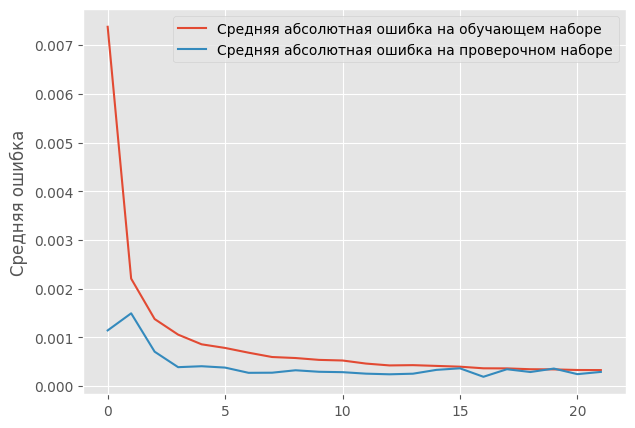

In [ ]:
# Обучение модели
history = model_lstm.fit_generator(
    trainDataGen,
    epochs=50,
    verbose=1,
    validation_data=testDataGen,
    callbacks=[early_stopping_callback]
)

# Вывод графиков
plt.plot(history.history['loss'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
model_lstm.save('/content/drive/MyDrive/glowbyte/model/model_lstm.h5')
model_lstm.save_weights('/content/drive/MyDrive/glowbyte/model/model_lstm_weights.h5')

# Submission

In [ ]:
# бейзлайн - предсказать потребление электроэнергии предыдущего дня
def shift_target(data):
    shifted_data = data.copy()
    shifted_data['baseline'] = shifted_data['target'].shift(-24)
    shifted_data['baseline'][-24:] = data['target'][-24:]
    return shifted_data

# Функция расчета результатов прогнозирования сети
def getPred(currModel, xVal, yVal, yScaler):
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  return (predVal, yValUnscaled)

# Функция получения метрик
def get_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2_scr = r2_score(y_true, y_pred)
    print("MSE: %.2f" % mse)
    print("MAE: %.2f" % mae)
    print("MAPE: %.2f" % mape)
    print("R2_score: %.2f" % r2_scr)
    # return mse, mae, mape, r2_scr

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/glowbyte/dataset/test_dataset.csv')
df_test = shift_target(df_test)
print(df_test['baseline'].isna().sum())
df_test.head()

0


,date,time,target,temp,temp_pred,weather_pred,weather_fact,baseline
0,2023-04-01,0,479.282,5.7,5.0,"пасм, 58%","пасм, морось",485.462
1,2023-04-01,1,445.182,5.7,5.0,"пасм, 58%","пасм, морось",453.605
2,2023-04-01,2,424.225,5.7,5.0,"пасм, 58%","пасм, морось",432.391
3,2023-04-01,3,413.866,5.0,4.0,"пасм, 71% дождь","пасм, дымка",420.610
4,2023-04-01,4,408.146,5.0,4.0,"пасм, 71% дождь","пасм, дымка",414.625


In [ ]:
# Загружаем модель
loaded_model = load_model('/content/drive/MyDrive/glowbyte/model/model_lstm.h5')
loaded_model.load_weights('/content/drive/MyDrive/glowbyte/model/model_lstm_weights.h5')

In [ ]:
# Предсказание модели
yVal_reshaped = yVal[0][:, -1, :]
(predVal_1, yValUnscaled) = getPred(model_lstm, xVal[0], yVal_reshaped, yScaler)
df_test['predict'] = predVal_1.tolist()

92/92 [==============================] - 1s 9ms/step


In [ ]:
df_test['predict_1'] = df_test['predict'].apply(lambda x: x[0])
df_test['predict_2'] = df_test['predict'].apply(lambda x: x[1])

In [ ]:
df_test = df_test[['date', 'target', 'baseline', 'predict_1', 'predict_2']]
df_test.head()

,date,target,baseline,predict_1,predict_2
0,2023-04-01,479.282,485.462,474.868073,439.644897
1,2023-04-01,445.182,453.605,442.463867,419.449677
2,2023-04-01,424.225,432.391,421.916229,408.973053
3,2023-04-01,413.866,420.610,412.925690,407.202454
4,2023-04-01,408.146,414.625,404.377228,404.183533


In [ ]:
get_metrics(df_test['target'], df_test['baseline'])

MSE: 288.06
MAE: 11.91
MAPE: 0.03
R2_score: 0.94


In [ ]:
get_metrics(df_test['target'], df_test['predict_1'])

MSE: 78.42
MAE: 7.08
MAPE: 0.02
R2_score: 0.98


In [ ]:
def shift_predict(data):
    shifted_data = data.copy()
    shifted_data['predict_2'] = shifted_data['target'].shift(1)
    shifted_data['predict_2'].iloc[0] = data['target'].iloc[-1]
    return shifted_data
df_test = shift_predict(df_test) # Отпускаем предсказания на строку вниз, т.к. это прогноз на следующий час
get_metrics(df_test['target'], df_test['predict_2'])

MSE: 441.51
MAE: 15.39
MAPE: 0.04
R2_score: 0.91


# main.py

In [ ]:
import re
import os

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras.models import load_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import pandas as pd
import numpy as np

# from utils import dct_to_replace, unique_words


class PreprocessorPredict:
    def __init__(self, filepath,
                 path_to_test='./test_dataset.csv',
                 path_to_model='models/model_lstm.h5',
                 path_to_model_weights='models/model_lstm_weights.h5',
                 path_to_save_csv='./predicted.csv',
                 xLen=150):

        if os.path.exists(filepath) and os.path.exists(path_to_test) and os.path.exists(path_to_model) and os.path.exists(path_to_model_weights):
            self.df_test = pd.read_csv(path_to_test)
            self.df_private = pd.read_csv(filepath)
            self.data = pd.concat([self.df_test, self.df_private])
            self.data = self.data.reset_index(drop = True)
            self.loaded_model = load_model(path_to_model)
            self.loaded_model.load_weights(path_to_model_weights)
            self.path_to_save = path_to_save_csv
        else:
            raise Exception('Укажите путь к тестовому и приватному датасету')

        self.xLen = xLen
        self.xTest = None
        self.yTest = None
        self.xScaler = None
        self.yScaler = None

    @staticmethod
    def extract_numbers(text):
        """Ищем числа в строке (вероятности возникновения погодного события)."""
        numbers = re.findall(r'\d+', text)
        lst = [int(num) for num in numbers]
        if len(lst) == 0:
            return 0
        return max(lst)

    @staticmethod
    def replace_strange_chars(text):
        """Удаляем все символы, оставляем только слова, удаляем лишние пробелы, переводим в lowercase."""
        cleaned_text = re.sub(r'[^a-zA-Zа-яА-ЯёЁ\s]', ' ', text)
        cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
        return cleaned_text.strip().lower()

    @staticmethod
    def replaced_words(row):
        """Заменяем слова из строки по совпадению ключей словаря на значения."""
        for pattern, replacement in dct_to_replace.items():
            row = re.sub(r'\b(?:' + pattern + r')\b', replacement, row)
        return row

    @staticmethod
    def fill_empty_cells(df):
        print('INFO: Заполнение пустых значений')
        df['temp_pred'].fillna(method='ffill', inplace=True)
        df['weather_pred'].fillna(method='ffill', inplace=True)
        df['weather_fact'].fillna(method='ffill', inplace=True)
        print('Пропущенных значений:', df.isna().sum().sum(), '\n')
        return df

    @staticmethod
    def add_features(df):
        df['date'] = pd.to_datetime(df['date'])                               # Столбец Date в формат datetime
        df['day_of_week'] = df['date'].dt.dayofweek                           # Номер дня в неделе
        df['month'] = df['date'].dt.month                                     # Номер месяца
        df['year'] = df['date'].dt.year                                       # Номер года
        df['date'] = (df['date'] - df['date'].min()).dt.days                  # Дату в количество прошедших дней с начальной даты

        print('INFO: Добавление полезных фичей')
        df['target_t_1'] = df['target'].shift(1)                              # Значение target на предыдущий час
        df['target_t_24'] = df['target'].shift(24)                            # Значение target на предыдущий день
        df['target_avg5'] = df['target'].rolling(window=5).mean()             # Среднее значение target за предыдущие 5 часов
        df['target_avg24'] = df['target'].rolling(window=24).mean()           # Среднее значение target за предыдущие 24 часа

        df['temp_pred_avg5'] = df['temp_pred'].rolling(window=5).mean()       # Среднее значение temp_pred за предыдущие 5 часов
        df['temp_pred_avg24'] = df['temp_pred'].rolling(window=24).mean()     # Среднее значение temp_pred за предыдущие 24 часа
        df['temp_avg5'] = df['temp'].rolling(window=5).mean()                 # Среднее значение temp за предыдущие 5 часов
        df['temp_avg24'] = df['temp'].rolling(window=24).mean()               # Среднее значение temp за предыдущие 24 часа

        for i in ['target', 'temp', 'temp_pred']:
            df[f'{i}_derivative_1'] = df[i].diff()                            # Производная 1 порядка
            df[f'{i}_derivative_2'] = df[i].diff()                            # Производная 2 порядка
            df[f'{i}_inverse'] = 1 / (df[i] + 0.01)                           # Обратное значение

        print('Размер датафрейма:', df.shape, '\n')
        return df

    def parsing_cat_cols(self, df):
        print('INFO: Парсим и кодируем в OHE столбцы погодных условиях')

        df['probability_pred'] = df['weather_pred'].apply(self.extract_numbers)
        df['probability_fact'] = df['weather_fact'].apply(self.extract_numbers)

        df['weather_pred'] = df['weather_pred'].apply(self.replace_strange_chars)
        df['weather_fact'] = df['weather_fact'].apply(self.replace_strange_chars)

        df['weather_pred'] = df['weather_pred'].apply(self.replaced_words)
        df['weather_fact'] = df['weather_fact'].apply(self.replaced_words)

        df['weather_pred'] = df['weather_pred'].str.split()
        df['weather_fact'] = df['weather_fact'].str.split()

        # OHE
        for word in unique_words:
            df[word + '_pred'] = df['weather_pred'].apply(lambda x: int(word in x))
            df[word + '_fact'] = df['weather_fact'].apply(lambda x: int(word in x))

        # Удаляем исходные категориальные переменные
        df = df.drop(['weather_pred', 'weather_fact'], axis=1)
        print('Размер датафрейма:', df.shape)
        return df

    def preprocessing_1(self):
        self.data = self.fill_empty_cells(self.data)
        self.data = self.add_features(self.data)
        self.data = self.parsing_cat_cols(self.data)
        self.data.fillna(value=0, inplace=True)
        self.data = np.array(self.data)

    def preprocessing_2(self):
        # Формирование параметров загрузки данных
        valLen = self.df_private.shape[0] + (self.xLen * 2)
        trainLen = self.data.shape[0] - valLen # Размер тренировочной выборки

        xTrain,xTest = self.data[:trainLen], self.data[trainLen+self.xLen:]
        xScaler = MinMaxScaler()
        xScaler.fit(xTrain)
        xTrain = xScaler.transform(xTrain)
        xTest = xScaler.transform(xTest)

        yTrain,yTest = np.reshape(self.data[:trainLen,2],(-1,1)), np.reshape(self.data[trainLen+self.xLen:,2],(-1,1))
        yScaler = MinMaxScaler()
        yScaler.fit(yTrain)
        yTrain = yScaler.transform(yTrain)
        yTest = yScaler.transform(yTest)
        yTrain = [yTrain[i:i + 2].tolist() for i in range(yTrain.shape[0])]
        yTest = [yTest[i:i + 2].tolist() for i in range(yTest.shape[0])]
        min_length_train = min(len(lst) for lst in yTrain)
        min_length_test = min(len(lst) for lst in yTrain)
        print(min_length_train, min_length_test)
        if min_length_train == 1:
            yTrain = [[lst[0], lst[0]] if len(lst) == 1 else lst for lst in yTrain]
        if min_length_test == 1:
            yTest = [[lst[0], lst[0]] if len(lst) == 1 else lst for lst in yTest]

        self.xTest = xTest
        self.yTest = yTest
        self.xScaler = xScaler
        self.yScaler = yScaler

    @staticmethod
    def getPred(currModel, xVal, yVal, yScaler):
        predVal = yScaler.inverse_transform(currModel.predict(xVal))
        yValUnscaled = yScaler.inverse_transform(yVal)
        return (predVal, yValUnscaled)

    @staticmethod
    # бейзлайн - предсказать потребление электроэнергии предыдущего дня
    def shift_target(data):
        shifted_data = data.copy()
        shifted_data['baseline'] = shifted_data['target'].shift(-24)
        shifted_data['baseline'][-24:] = data['target'][-24:]
        return shifted_data

    @staticmethod
    def shift_predict(data):
        shifted_data = data.copy()
        shifted_data['predict_2'] = shifted_data['target'].shift(1)
        shifted_data['predict_2'].iloc[0] = data['target'].iloc[-1]
        return shifted_data

    @staticmethod
    # Функция получения метрик
    def get_metrics(y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        mape = mean_absolute_percentage_error(y_true, y_pred)
        r2_scr = r2_score(y_true, y_pred)
        print("MSE: %.2f" % mse)
        print("MAE: %.2f" % mae)
        print("MAPE: %.2f" % mape)
        print("R2_score: %.2f" % r2_scr)
        # return mse, mae, mape, r2_scr

    def gener_datagen(self):
        DataGen = TimeseriesGenerator(
            self.xTest, self.yTest,
            length=self.xLen,
            sampling_rate=1,
            batch_size=len(self.xTest))

        xVal, yVal = [], []
        for i in DataGen:
            xVal.append(i[0])
            yVal.append(i[1])
        xVal = np.array(xVal)
        yVal = np.array(yVal)
        print(DataGen[0][0].shape, DataGen[0][1].shape)
        print(self.df_private.shape[0])
        return xVal, yVal


    def predict(self):
        self.preprocessing_1()
        self.preprocessing_2()
        xVal, yVal = self.gener_datagen()

        # Предсказание модели
        yVal_reshaped = yVal[0][:, -1, :]
        (predVal_1, yValUnscaled) = self.getPred(self.loaded_model, xVal[0], yVal_reshaped, self.yScaler)
        self.df_private = self.shift_target(self.df_private)                    # baseline

        self.df_private['predict_today_tomorrow'] = predVal_1.tolist()

        self.df_private['predict'] = self.df_private['predict_today_tomorrow'].apply(lambda x: x[0])
        self.df_private['predict_2'] = self.df_private['predict_today_tomorrow'].apply(lambda x: x[1])
        self.df_private = self.df_private[['date', 'target', 'baseline', 'predict', 'predict_2']]
        df_ex = self.df_private.copy()
        print('\n\n\nМетрика target - baseline')
        self.get_metrics(self.df_private['target'], self.df_private['baseline'])
        print('\n\nМетрика target - predict на сегодня', '\n')
        self.get_metrics(self.df_private['target'], self.df_private['predict'])
        self.df_private = self.shift_predict(self.df_private) # Отпускаем предсказания на строку вниз, т.к. это прогноз на следующий час
        print('\n\nМетрика target - predict_2 на следующий час', '\n')
        self.get_metrics(self.df_private['target'], self.df_private['predict_2'])
        self.df_private = self.df_private[['date', 'predict']]
        self.df_private.to_csv(self.path_to_save, index=False)
        print('\n\nФайл с предсказаниями сохранен по пути:', self.path_to_save)
        return df_ex


if __name__ == '__main__':
    filepath='/content/drive/MyDrive/glowbyte/dataset/test_dataset.csv' # Указать путь к приватному датасету
    inf=1
    if inf:
        path_to_test='/content/drive/MyDrive/glowbyte/dataset/train_dataset.csv'
    else:
        path_to_test='/content/drive/MyDrive/glowbyte/dataset/test_dataset.csv'
    path_to_model='/content/drive/MyDrive/glowbyte/model/model_lstm.h5'
    path_to_model_weights='/content/drive/MyDrive/glowbyte/model/model_lstm_weights.h5'
    path_to_save_csv='./predicted.csv'
    sol = PreprocessorPredict(filepath, path_to_test, path_to_model, path_to_model_weights, path_to_save_csv)
    df = sol.predict()

INFO: Заполнение пустых значений
Пропущенных значений: 0 

INFO: Добавление полезных фичей
Размер датафрейма: (40152, 27) 

INFO: Парсим и кодируем в OHE столбцы погодных условиях
Размер датафрейма: (40152, 91)
1 1
(2928, 150, 91) (2928, 2, 1)
2928
92/92 [==============================] - 2s 10ms/step



Метрика target - baseline
MSE: 288.06
MAE: 11.91
MAPE: 0.03
R2_score: 0.94


Метрика target - predict на сегодня 

MSE: 78.42
MAE: 7.08
MAPE: 0.02
R2_score: 0.98


Метрика target - predict_2 на следующий час 

MSE: 441.51
MAE: 15.39
MAPE: 0.04
R2_score: 0.91


Файл с предсказаниями сохранен по пути: ./predicted.csv


Бейзлайн - предсказать потребление электроэнергии предыдущих суток

In [ ]:
df.head()

,date,target,baseline,predict,predict_2
0,2023-04-01,479.282,485.462,474.868073,439.644897
1,2023-04-01,445.182,453.605,442.463867,419.449677
2,2023-04-01,424.225,432.391,421.916229,408.973053
3,2023-04-01,413.866,420.610,412.925690,407.202454
4,2023-04-01,408.146,414.625,404.377228,404.183533


In [ ]:
sol.df_private.head()

,date,predict
0,2023-04-01,474.868073
1,2023-04-01,442.463867
2,2023-04-01,421.916229
3,2023-04-01,412.925690
4,2023-04-01,404.377228


In [ ]:
yScaler.inverse_transform(yVal[0][0])

array([[479.282],
       [445.182]])

In [ ]:
xx = xScaler.inverse_transform(xVal[0][160])
xx[:, 2][-1]

544.4829999999998